In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Reference Model

In [3]:
# Loading trajectory
results=pd.read_csv('Resultscounty.txt',header=None,sep='\t')
results.columns=['ID','time','county','S','E','A','I','R','P','D']
# results=pd.merge(results,parameters,on='ID')
results.sort_values(['ID','time'],ascending=True,inplace=True)
dictionary=pd.read_csv('countydictionary.csv')
dictionary.columns=['COUNTY CODE','COUNTY NAME','county']
results=pd.merge(results,dictionary,on='county')
# results=resultspatch[['time','COUNTY NAME','S','E','A','I','R','P','D','beta','tauexposed','taupresymp','tauI','casefatalityrate','COUNTY CODE']]  
results=results[['ID','time','COUNTY NAME','S','E','A','I','R','P','D']]
results.loc[:,"S":"D"] = results.loc[:,"S":"D"].div(results.loc[:,"S":"D"].sum(axis =1), axis=0)

# Getting number of patches
patches = np.unique(results['COUNTY NAME'].values)
M = len(patches)
# Getting the time length
time = np.unique(results['time'].values)
T = len(time)
# Getting number of trajectories
IDs = np.unique(results['ID'].values)
N = len(IDs)
np.set_printoptions(threshold=np.inf)
# Number of compartments
C = 7
ref_traj = np.empty((N, T, M, C))
for n in IDs:
    for m, patch_name in enumerate(patches):
        ID = results.loc[results['ID'].isin([str(n)])]
        county = ID.loc[ID['COUNTY NAME'] == patch_name]
        traj_county = county[['S','E','A','I','R','P','D']].to_numpy()
        ref_traj[n,:,m,:] = traj_county
print (np.shape(ref_traj))

(10, 201, 62, 7)


Plotting 62 patches in a 7 x 9 grid


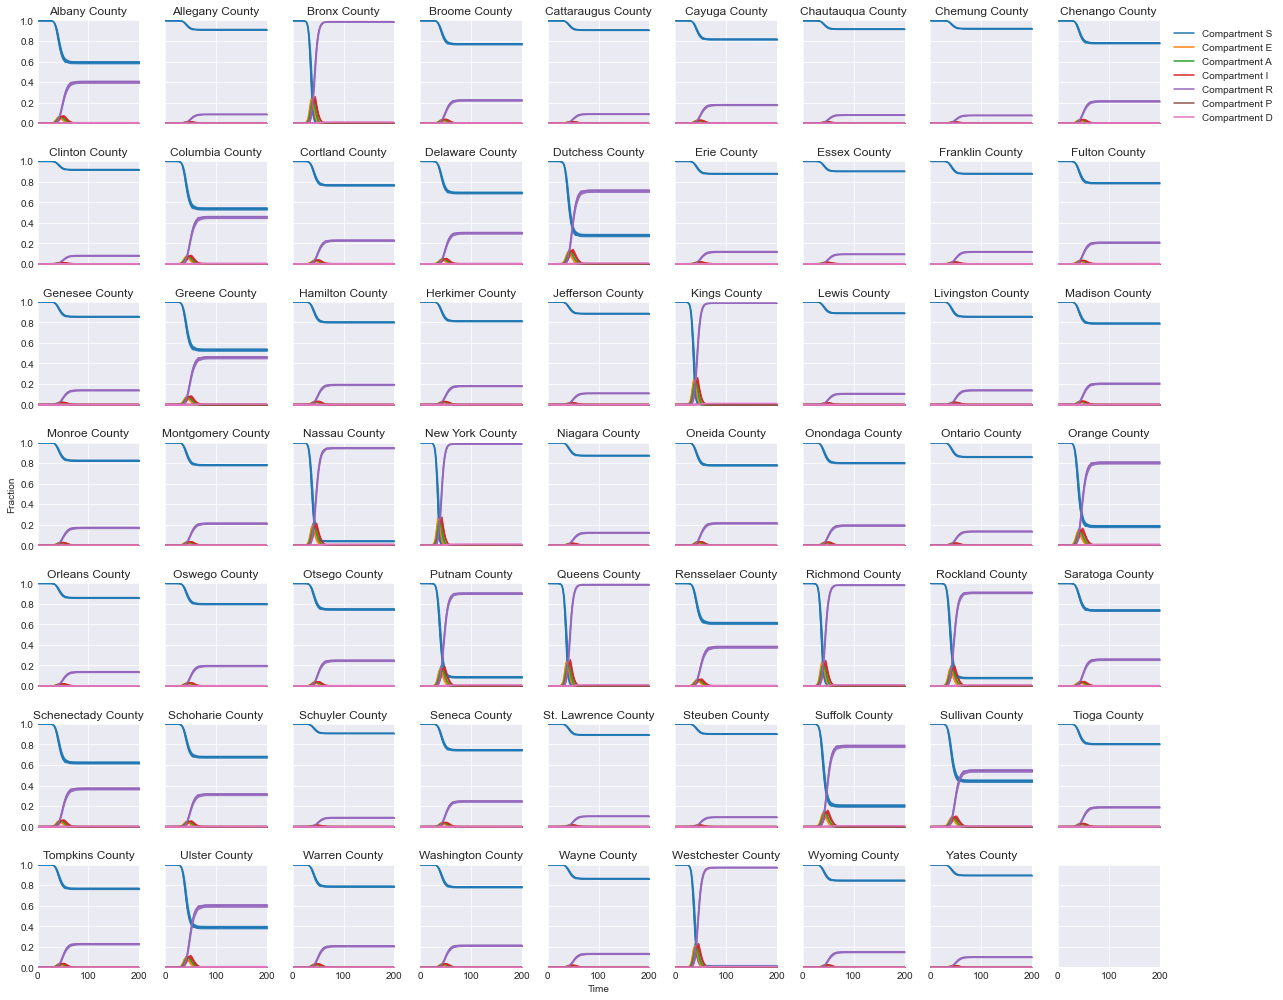

In [4]:
patch_quantile(ref_traj, patch_names = patches, figsize=(18, 14), alpha=0.9, names=['S','E','A','I','R','P','D'])
plt.savefig('patch_quantile.png',dpi=400)
plt.show()

In [5]:
import plotly.graph_objs as go
import plotly.figure_factory as ff 
process_traj = False
if process_traj == True:
    for t in range(T):
        infected_portion = [round(ref_traj[0,t,i,3],2) for i in range(M)]
        zipcodes = dictionary['COUNTY CODE']
        fig = ff.create_choropleth(fips=zipcodes, 
                                   scope=['New York'],
                                   values=infected_portion,
                                   title='NY COVID-19 Infected Population Fraction by County',
                                   county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
                                   state_outline={'width': .5}
                                   )


        fig.update_layout(legend=dict(
            title='Infected Fraction',
            yanchor="top",
            y=0.95,
            xanchor="left",
            x=0.9,

        ))
        fig.add_annotation(dict(font=dict(color='black',size=30),
                                                x=0.4,
                                                y=0.12,
                                                showarrow=False,
                                                text="Day {}".format(t),
                                                textangle=0,
                                                xanchor='left',
                                                xref="paper",
                                                yref="paper"
                                                ))

        fig.layout.template = {'layout': {'font': {'family': 'Britannic Bold', 'size': 20}}}
        fig.write_image("NY_map//traj_" + str(t) +
                            ".png",width = 2048, height =1060)

In [6]:
# Run this for saving plots
if process_traj == True:
    for i in range(M):
        traj_quantile(ref_traj[:,:,i,:], names=['S','E','A','I','R','P','D'], add_legend=False, add_title = patches[i], plot_means=True)
        fig = plt.gcf()
        fig.set_size_inches(4, 4)
        #plt.savefig('{}.png'.format(patches[i]),dpi=400)
        plt.close()

In [9]:
# load mobility matrix
networkCounty=pd.read_csv('networkCounty.txt',header=None,sep=' ')
networkCounty.columns=['ID','County','mobility_parameter']
mobility_matrix = networkCounty.reset_index().groupby(['County'])['mobility_parameter'].apply(np.array).to_numpy()
networkCounty = networkCounty[['ID','mobility_parameter']]
Mobility_martix = np.empty([0,M])
mobility_parameter_row = np.zeros(M)
for i,row in networkCounty.iterrows():
    mobility_parameter_row[networkCounty.loc[i, 'ID']] = networkCounty.loc[i, 'mobility_parameter']
    if i < networkCounty.shape[0]-1:
        if networkCounty.loc[i+1, 'ID'] == 0:
            Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
            mobility_parameter_row = np.zeros(M)
    else:
         Mobility_martix = np.append(Mobility_martix, [mobility_parameter_row], axis=0)
assert (np.shape(Mobility_martix)==(M,M))
Mobility_martix_norm = Mobility_martix / np.sum(Mobility_martix, axis=1).reshape(M,1)


## Sample SEAIRPD

In [18]:
# compartment parameters
compartments = ['E','A','I','R','P','D']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
tmat.add_transition('E', 'I', 7, 2)
tmat.add_transition('I', 'R', 3, 2)
param_model = maxentep.ParameterJoint(np.zeros((M,)), Mobility_martix_norm * 0.8, tmat, name='unbiased_model')

TypeError: Invalid type for initial value: <class 'tensorflow.python.framework.ops.EagerTensor'> (expected Python scalar, list or tuple of values, or numpy.ndarray).


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

(201, 62, 7)


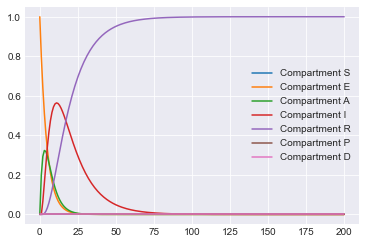

In [42]:
infect = maxentep.contact_infection_func(infections_compartments)
model = maxentep.MetaModel(infect, T)
traj = model(Mobility_martix_norm, tmat.value, start, 0.1)[0]
print (np.shape(traj))
plt.plot(traj[:,0])
plt.legend(['Compartment S','Compartment E','Compartment A','Compartment I','Compartment R','Compartment P','Compartment D'])


In [ ]:

from maxentep import SIRModel, traj_quantile

# make trajectories
N = 500
L = 60
trajs = np.empty((N, L, 3))
alphas = ss.uniform.rvs(0.01, 0.3, size=N)
betas = ss.uniform.rvs(0.01, 2, size=N)
infected = ss.beta.rvs(1, 10, size=N)
susceptible = ss.beta.rvs(5, 2, size=N)
for i, a, b, I, S in zip(range(N), alphas, betas, infected, susceptible):
    model = SIRModel([S, I, 1 - S - I], a, b, L)
    trajs[i] = model()

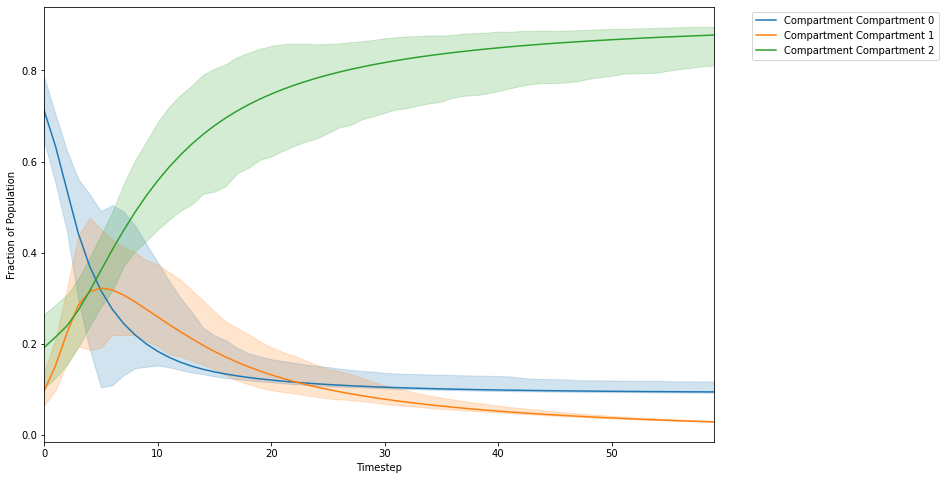

In [5]:
plt.figure(figsize=(12,8))
traj_quantile(trajs)
plt.show()

[5.50000815e-01 8.14981664e-07]


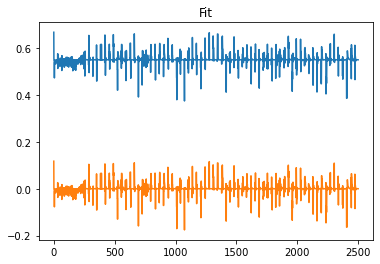

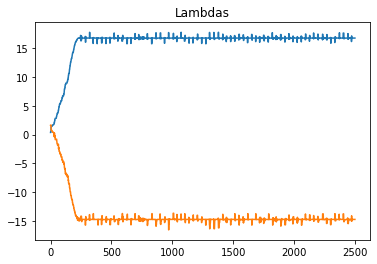

In [6]:
from maxentep import reweight_laplace
restraints = [[0.2, 0.05, 10, 1], [0.75, 0.0, 50, 2]]
ITERS = 2500
fit = np.empty((ITERS, len(restraints)))
all_lambdas = np.empty((ITERS, len(restraints)))
scales = []
def callback(i, weights, lambdas, e_gk, agreement, scale):
    all_lambdas[i, :] = lambdas
    fit[i, :] = e_gk
    scales.append(scale)
w,proc_restraints = reweight_laplace(trajs, restraints, learning_rate=1, iter=ITERS, callback=callback)
print(fit[-1])
plt.figure()
plt.title('Fit')
plt.plot(fit)
plt.show()

plt.figure()
plt.title('Lambdas')
plt.plot(all_lambdas)
plt.show()

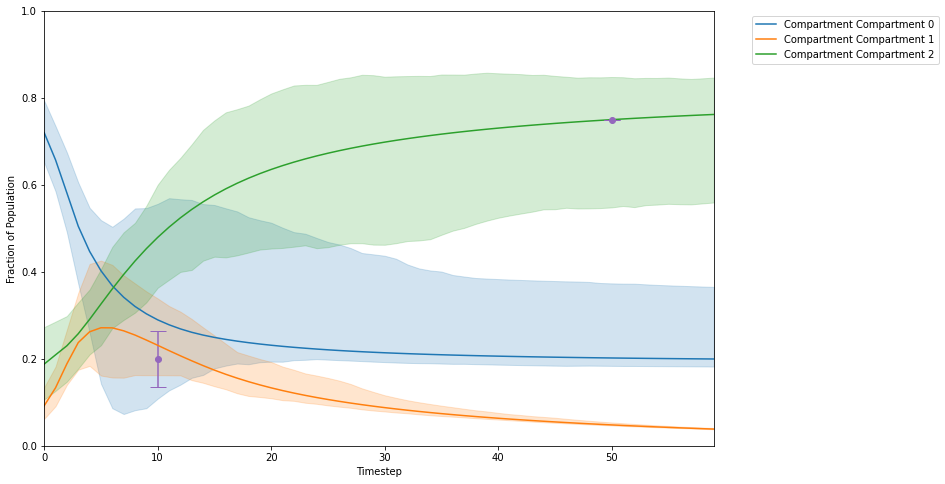

In [7]:
plt.figure(figsize=(12,8))
traj_quantile(trajs, w)
for i, (pr, r) in enumerate(zip(proc_restraints, restraints)):
    plt.plot(r[2], r[0], 'o', color='C4')
    plt.errorbar(r[2], r[0], yerr=pr.prior.expected(all_lambdas[-1][i]), color='C4', capsize=8)
plt.ylim(0,1)
plt.show()

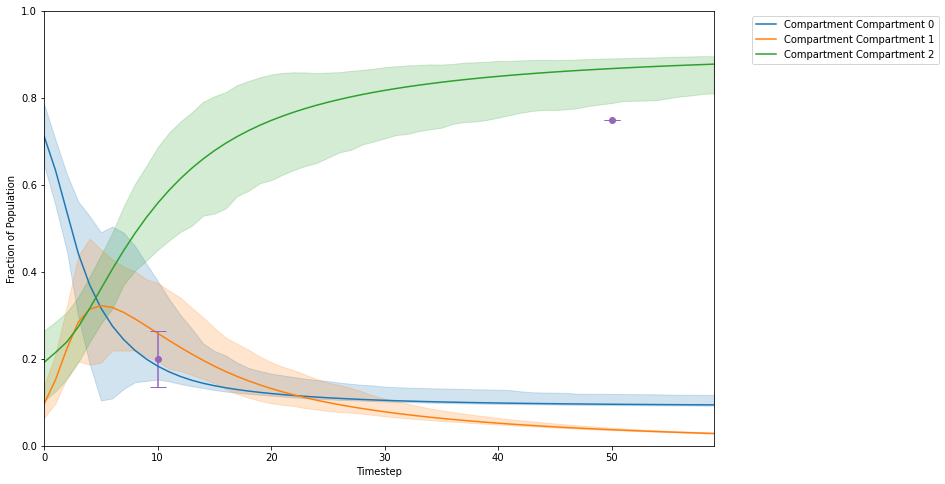

In [8]:
plt.figure(figsize=(12,8))
traj_quantile(trajs)
for i, (pr, r) in enumerate(zip(proc_restraints, restraints)):
    plt.plot(r[2], r[0], 'o', color='C4')
    plt.errorbar(r[2], r[0], yerr=pr.prior.expected(all_lambdas[-1][i]), color='C4', capsize=8)
plt.ylim(0,1)
plt.show()